# M06 Homework

- Name: Sam Remmey
- Net ID: sqr8ap
- URL of this file in GitHub: https://github.com/sqr8ap/DS5001-2025-01-R/blob/m06/lessons/M06_CusteringSimilarity/M06_HW.ipynb

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_hone = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [376]:
data_prefix = 'austen-melville'
OHCO = ['book_id', 'chap_id']
OHCO_token = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
bag = 'CHAPS'
colors = "YlGnBu"
tf_agg = 'sum'

In [378]:
import pandas as pd
import numpy as np
import plotly_express as px
import seaborn as sns; sns.set()
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

## Pre-Question Tasks

In [380]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index('book_id')
TOKEN = pd.read_csv(f'{output_dir}/{data_prefix}-CORPUS.csv').set_index(OHCO_token).dropna()

In [382]:
LIB.head()

,source_file_path,author,title,chap_regex,book_len,n_chaps
book_id,,,,,,
105,/Users/Samantha/Desktop/MSDS/DS5001/data/guten...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24
121,/Users/Samantha/Desktop/MSDS/DS5001/data/guten...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31
141,/Users/Samantha/Desktop/MSDS/DS5001/data/guten...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48
158,/Users/Samantha/Desktop/MSDS/DS5001/data/guten...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55
161,/Users/Samantha/Desktop/MSDS/DS5001/data/guten...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50


In [384]:
# Add feature to LIB for publication year
title_to_year = {
    'EMMA': '1815 EMMA',
    'LADY SUSAN': '1794 LADY SUSAN',
    'LOVE AND FREINDSHIP SIC': '1790 LOVE AND FREINDSHIP',
    'MANSFIELD PARK': '1814 MANSFIELD PARK',
    'NORTHANGER ABBEY': '1803 NORTHANGER ABBEY',
    'PERSUASION': '1818 PERSUASION',
    'PRIDE AND PREJUDICE': '1813 PRIDE AND PREJUDICE',
    'SENSE AND SENSIBILITY': '1811 SENSE AND SENSIBILITY'
}
LIB['year'] = LIB['title'].map(title_to_year)

In [386]:
# Bring in functions from last homework, modify TFIDF to include DFIDF
def gen_bow(TOKENS, OHCO_LEVEL='CHAPS'):
    '''
    This function takes a tokens table and a choice of bag and returns a BOW representation in the form of a document-term count matrix. 

    Parameters
    TOKENS: tokens table; a dataframe
    OCHO_LEVEL: choice of bag; a string (either 'BOOKS', 'CHAPS', 'PARAS' or 'SENTS'); defaults to 'CHAPS'

    Returns
    DTCM: document-term count matrix
    '''
    
    bags = dict(
        SENTS = OHCO[:4],
        PARAS = OHCO[:3],
        CHAPS = OHCO[:2],
        BOOKS = OHCO[:1])
    
    BOW = TOKENS.groupby(bags[OHCO_LEVEL]+['term_str']).term_str.count().to_frame('n')
    DTCM = BOW.n.unstack(fill_value=0)

    return DTCM

In [388]:
def gen_tfidf(DTCM, TF_METHOD='sum'):
    '''
    This function takes a BOW table (DTCM) and type of tf metric and returns the TFIDF values for the BOW. 

    Parameters
    DTCM: BOW table; a dataframe
    TF_METHOD: a string; either 'sum', 'max', 'log', 'raw', 'double_norm' or 'binary'; defaults to 'sum'

    Returns
    TFIDF: a dataframe
    '''

    tf_norm_k = 0.5
    idf_method = 'standard'
    gradient_cmap = 'YlGnBu'
    tf = {
        'sum': (DTCM.T / DTCM.T.sum()).T,
        'max': (DTCM.T / DTCM.T.max()).T,
        'log': (np.log2(1 + DTCM.T)).T,
        'raw':  DTCM,
        'double_norm': (DTCM.T / DTCM.T.max()).T,
        'binary': DTCM.T.astype('bool').astype('int').T}

    TF = tf[TF_METHOD]

    DF = DTCM.astype('bool').sum() 

    N = DTCM.shape[0]   
    
    IDF = np.log2(N / DF)

    TFIDF = TF * IDF
    DFIDF = DF * IDF
    
    return TFIDF, DFIDF

In [390]:
# Apply to Austen's works only using chapters as bags and max as the tf method
LIB = LIB.loc[LIB['author'] == 'AUSTEN, JANE']
TOKEN = TOKEN.loc[TOKEN.index.get_level_values('book_id').isin([158, 946, 1212, 141, 121, 105, 1342, 161])]

my_dtcm = gen_bow(TOKEN) # default bag level is chapter
idfs = gen_tfidf(my_dtcm, TF_METHOD = 'max')
TFIDF, DFIDF = idfs[0], idfs[1]

In [392]:
# Reduce number of features in TFIDF matrix

## First generate VOCAB table
VOCAB = TOKEN.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = TOKEN[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = TOKEN[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)

## Filter and reduce TFIDF matrix
pos = {"NN", "NNS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "JJ", "JJR", "JJS", "RB", "RBR", "RBS"}
pos_match = VOCAB[VOCAB['max_pos'].isin(pos)].index
filtered_dfidf = DFIDF[DFIDF.index.isin(pos_match)]
top_terms = filtered_dfidf.nlargest(1000).index
TFIDF_reduced = TFIDF[top_terms]

In [394]:
TFIDF_reduced.sample(5)

term_str          forward  greatest   respect      stay  thinking    assure  \
book_id chap_id                                                               
121     10       0.000000  0.000000  0.008478  0.016955  0.000000  0.017094   
1342    35       0.011259  0.000000  0.011259  0.000000  0.000000  0.000000   
        22       0.000000  0.000000  0.000000  0.067556  0.022519  0.022703   
        39       0.000000  0.020588  0.000000  0.041177  0.000000  0.000000   
161     48       0.030025  0.030025  0.000000  0.000000  0.000000  0.000000   

term_str          fortune  marriage  believed   entered  ...  number  \
book_id chap_id                                          ...           
121     10       0.000000  0.017094  0.016818  0.033635  ...     0.0   
1342    35       0.011351  0.034054  0.033504  0.000000  ...     0.0   
        22       0.045405  0.068108  0.000000  0.022336  ...     0.0   
        39       0.020757  0.000000  0.000000  0.000000  ...     0.0   
161     48       0.000000  0.000000  0.000000  0.029781  ...     0.0   

term_str          picture  powers  scene  sensations    stairs     tired  \
book_id chap_id                                                            
121     10       0.017011     0.0    0.0         0.0  0.000000  0.068044   
1342    35       0.000000     0.0    0.0         0.0  0.000000  0.000000   
        22       0.045185     0.0    0.0         0.0  0.000000  0.000000   
        39       0.000000     0.0    0.0         0.0  0.041312  0.000000   
161     48       0.000000     0.0    0.0         0.0  0.000000  0.000000   

term_str            truly    unable      till  
book_id chap_id                                
121     10       0.000000  0.000000  0.013713  
1342    35       0.022593  0.045185  0.004553  
        22       0.000000  0.000000  0.009106  
        39       0.000000  0.000000  0.000000  
161     48       0.000000  0.000000  0.012142  

[5 rows x 1000 columns]

In [396]:
# Collapse TFIDF matrix so it contains mean TFIDF for each term by book
TFIDF_collapsed = TFIDF_reduced.groupby(OHCO[:1]).mean()

In [398]:
TFIDF_collapsed

term_str,forward,greatest,respect,stay,thinking,assure,fortune,marriage,believed,entered,...,number,picture,powers,scene,sensations,stairs,tired,truly,unable,till
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.009262,0.003233,0.006140,0.010584,0.011340,0.010205,0.013589,0.011468,0.008962,0.003481,...,0.008072,0.007001,0.004024,0.004032,0.007360,0.003043,0.006822,0.009549,0.004557,0.007750
121,0.006748,0.007326,0.004111,0.008810,0.008241,0.008954,0.010054,0.005660,0.009190,0.012626,...,0.008718,0.003062,0.004966,0.003930,0.002145,0.003010,0.015114,0.002360,0.001299,0.010037
141,0.009500,0.010356,0.009049,0.009412,0.010821,0.004308,0.006946,0.007412,0.008376,0.005688,...,0.004042,0.004515,0.005477,0.013626,0.007835,0.002409,0.006576,0.004525,0.003468,0.009845
158,0.008882,0.007157,0.011402,0.011392,0.014596,0.014604,0.010334,0.009475,0.011059,0.006001,...,0.004511,0.012285,0.007770,0.002252,0.006615,0.001884,0.009169,0.006629,0.000696,0.009874
161,0.006474,0.009488,0.006497,0.008128,0.005347,0.009847,0.012934,0.013288,0.008158,0.012745,...,0.005238,0.006209,0.002262,0.002234,0.001596,0.011649,0.003723,0.001873,0.011270,0.010393
946,0.010188,0.015570,0.010156,0.005638,0.001255,0.005513,0.005375,0.021950,0.009788,0.010153,...,0.000000,0.000000,0.008040,0.000000,0.005358,0.000613,0.003918,0.003359,0.001120,0.009533
1212,0.001501,0.010051,0.003126,0.000884,0.003517,0.011138,0.011411,0.016403,0.000000,0.013335,...,0.002193,0.004968,0.004013,0.007929,0.002735,0.000692,0.003257,0.006191,0.002869,0.007163
1342,0.006757,0.005553,0.009518,0.012313,0.007312,0.013715,0.014328,0.020465,0.010656,0.010073,...,0.002116,0.005842,0.003589,0.009177,0.001252,0.010959,0.001891,0.003882,0.008668,0.011637


In [400]:
# Compute distance measures between all pairs of books
L0 = TFIDF_collapsed.astype('bool').astype('int')    # Binary (Pseudo L)
L1 = TFIDF_collapsed.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF_collapsed.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [402]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(105, 121), (105, 141), (105, 158), (105, 161), (105, 946)]

In [404]:
PAIRS['cityblock'] = pdist(TFIDF_collapsed, 'cityblock')
PAIRS['cosine'] = pdist(TFIDF_collapsed, 'cosine')
PAIRS['euclidean'] = pdist(L2, 'euclidean')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['js'] = pdist(L1, 'jensenshannon')

In [406]:
# Create hierarchical agglomerative cluster diagrams
def hac(sims, linkage_method='weighted', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.year.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

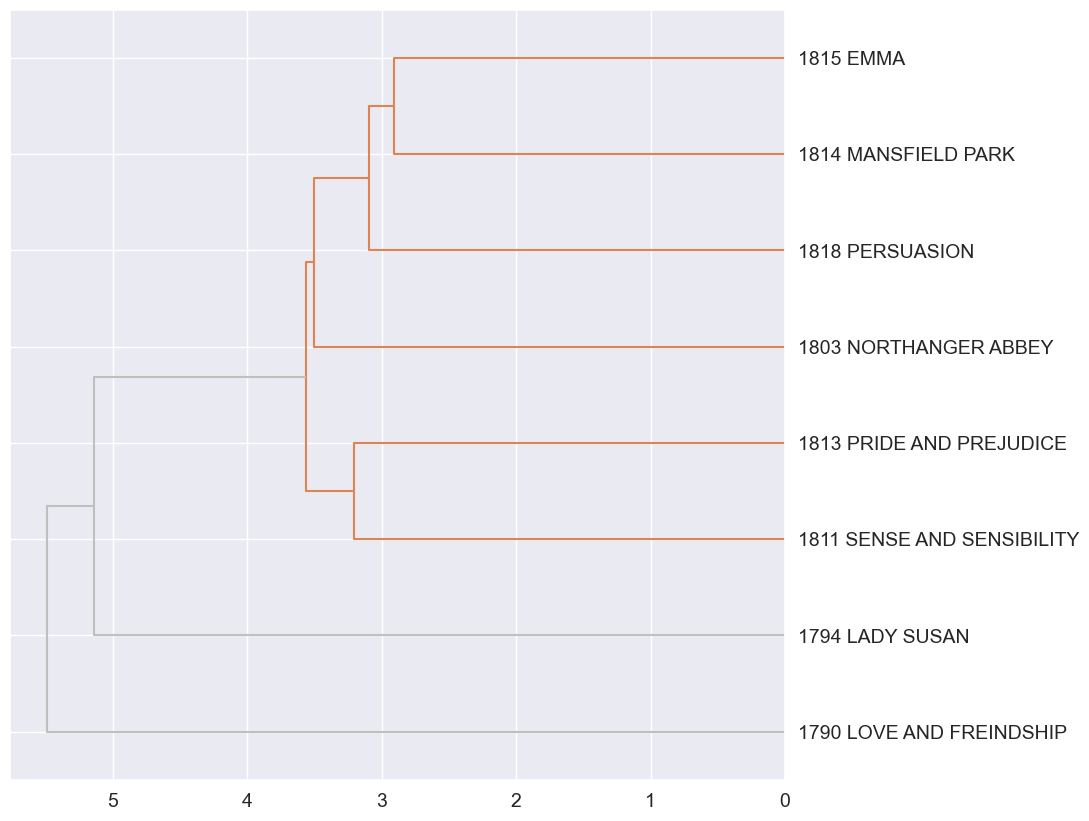

In [408]:
hac(PAIRS.cityblock, color_thresh=4)

<Figure size 640x480 with 0 Axes>

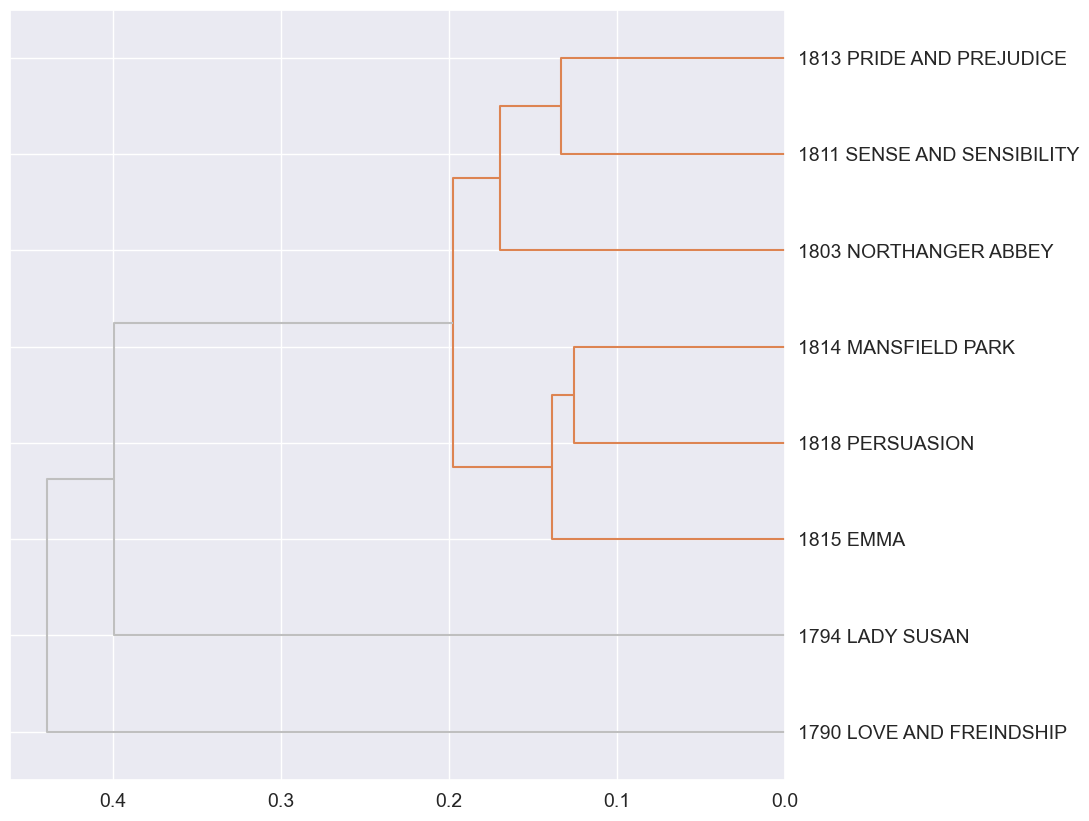

In [410]:
hac(PAIRS.cosine, linkage_method='ward', color_thresh=0.2)

<Figure size 640x480 with 0 Axes>

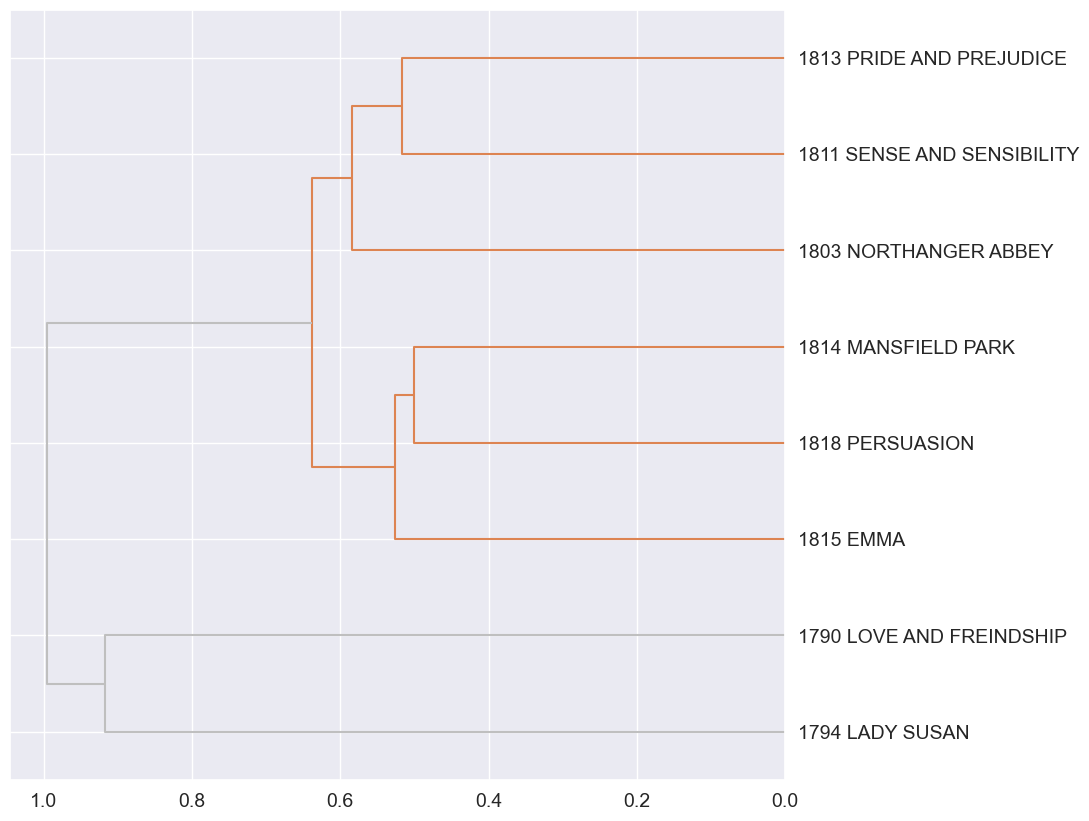

In [412]:
hac(PAIRS.euclidean, linkage_method='ward', color_thresh=0.7)

<Figure size 640x480 with 0 Axes>

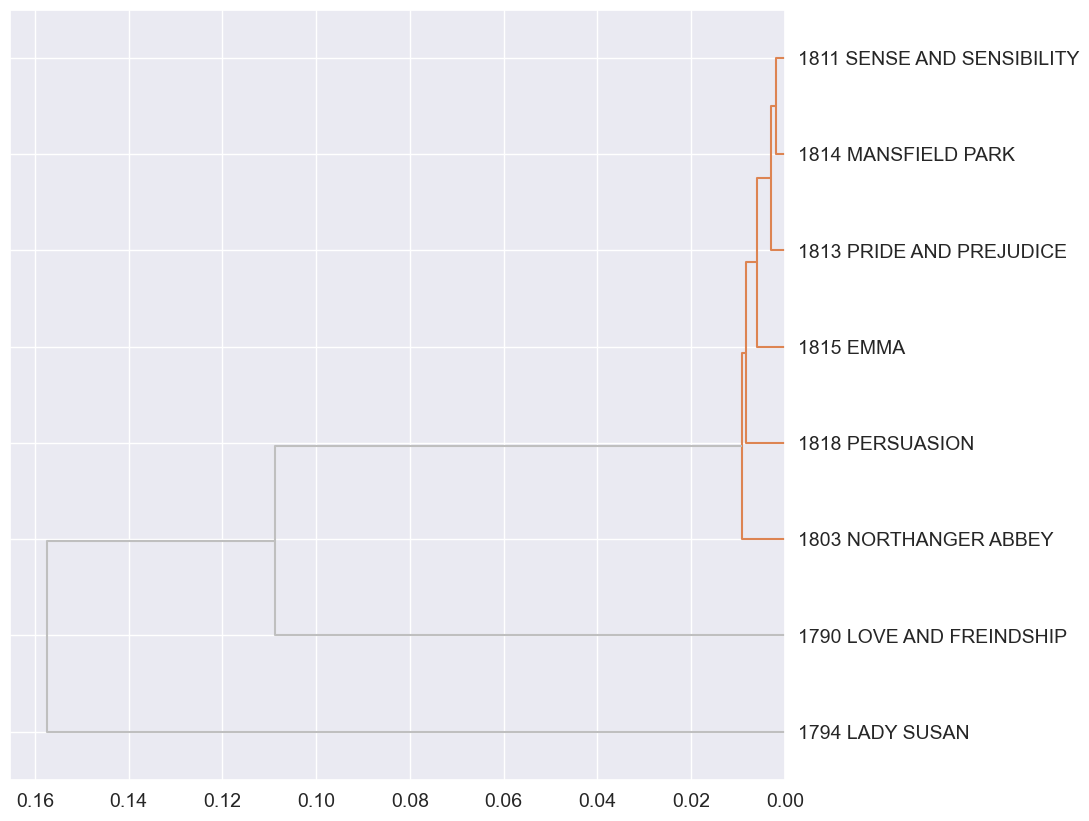

In [414]:
hac(PAIRS.jaccard, color_thresh=0.1)

<Figure size 640x480 with 0 Axes>

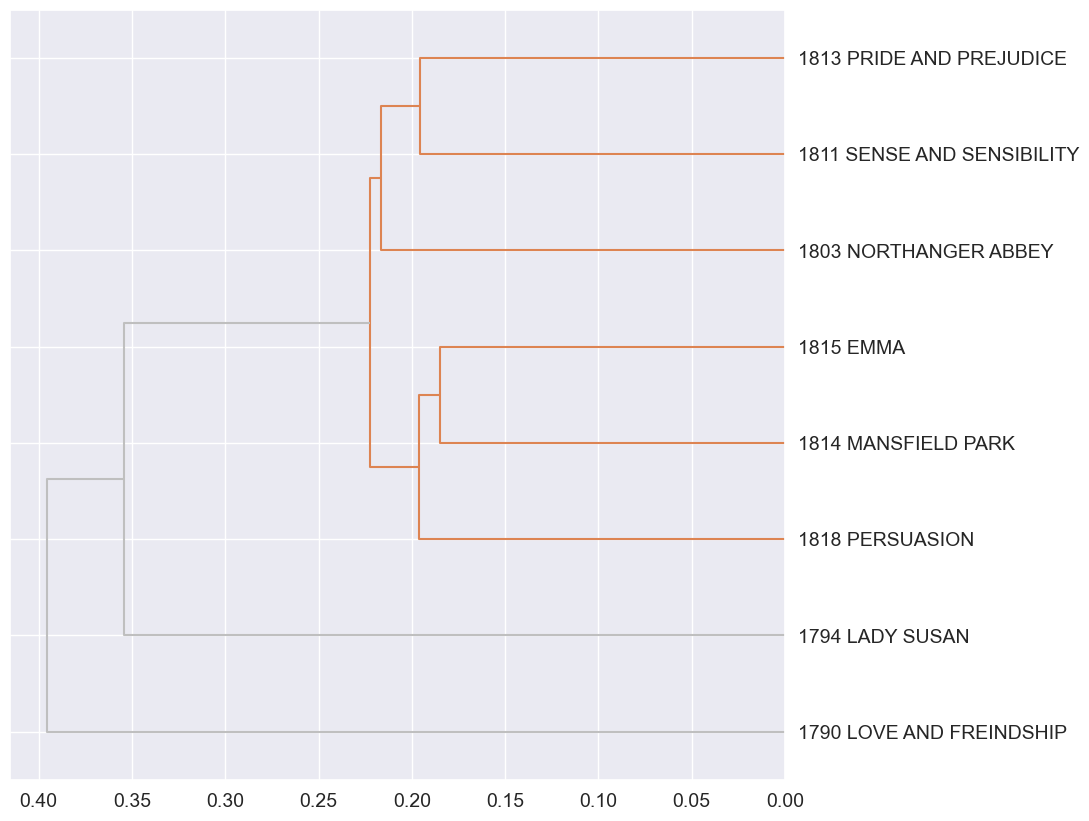

In [416]:
hac(PAIRS.js, color_thresh=0.25)

## Questions:

#### 1. What are the top 10 nouns by DFIDF, sorted in descending order? Include plural nouns, but don't include proper nouns. 

In [418]:
nouns = {"NN", "NNS"}  # Singular and plural nouns - no proper nouns
matched_nouns = VOCAB[VOCAB['max_pos'].isin(nouns)].index
DFIDF_nouns = DFIDF[DFIDF.index.isin(matched_nouns)]

In [420]:
DFIDF_nouns = pd.DataFrame(DFIDF_nouns)
DFIDF_nouns.columns = ['value']
DFIDF_nouns.sort_values(by='value', ascending=False).head(10)

,value
term_str,
respect,177.266344
fortune,177.261968
marriage,177.261968
ladies,177.258990
question,177.258990
farther,177.240001
behaviour,177.240001
advantage,177.217644
voice,177.209470


#### 2. Grouping your TFIDF results by book, and taking the mean TFIDF of all terms per book, what is Austen's most "significant" book? This value is computed from the TFIDF matrix your function returned.

In [422]:
# I'm not sure if we're expected to use the TFIDF matrix with book_id and chap_id or
## the collapsed one that's just by book. So I'll do both, but I think the collapsed
## one is the correct approach here. Though they should result in the same answer.

# book_id and chap_id:
TFIDF_q2 = TFIDF_reduced.groupby(level="book_id").mean().mean(axis=1)
print(TFIDF_q2.idxmax())
print(TFIDF_q2.max())

158
0.008163344617015582


In [424]:
# collapsed (just book_id):
print(TFIDF_collapsed.mean(axis=1).idxmax())
print(TFIDF_collapsed.mean(axis=1).max())

158
0.008163344617015582


As expected, both approaches resulted in the same output. Austen's most "significant" book is **Emma**. However, these TFIDF dataframes only include the top 1000 terms, not all terms. Again I'm not clear on whether we were supposed to include all terms and not just the top 1000, but I assumed we only needed to use the top 1000 given that we had to generate the top terms prior to starting these questions. Just in case I'll include the result using all terms as well:

In [426]:
TFIDF_q2_AllTerms = TFIDF.groupby(level="book_id").mean().mean(axis=1)
print(TFIDF_q2_AllTerms.idxmax())
print(TFIDF_q2_AllTerms.max())

121
0.0018510292773293439


If we use the original TFIDF matrix with all terms and not just the top 1000, we end up with **Northanger Abbey** as Austen's most "significant" book. 

#### 3. Using the dendograms you generated, which distance measure most clearly distinguishes Austen's two youthful works from her later works? That is, which measure show the greatest separation between the first two work and the rest? Note that the two youthful works were published before 1800.

Based on the dendrograms, it looks like the farthest relative distance between the cluster of newer works and one of the older works occurs in the jaccard graph. The cosine metric also provided distinct separation between the newer works and one of the youthful works. Disregarding x-axis scaling, the longest line between the newer works and either of the older works occurs in the **jaccard** dendrogram. However, the only metric that branched first with two main clusters (one with two youthful works, one with the rest) was euclidean distance. 

#### 4. Do any of the distance measures produce dendrograms with works sorted in the exact order of their publication years? 

No, none of the distance measures produced dendrograms with works sorted in the exact order of their publication years. 

#### 5. Some literary critics believe that Northanger Abbey is, among Austen's mature works, the one that most resembles her juvenalia, i.e. her two works written as a young adult. Which distance measure dendrograms appear to corroborate this thesis? In other words, do any of them show that Northanger Abbey is closer to her juvenalia than the her other adult works?

It doesn't look like any of the dendrograms corroborate this thesis with much strength. The only diagram that places Northanger Abbey next to one of her older works is the jaccard dendrogram, but the distance between the two is quite significant relative to the scale. However, in all of the dendrograms, Northanger Abbey is horizontally the closest of any of the newer works to the merge point between new and old works--though not by much. 